# BerryBox

Code to process images taken in a controlled lightbox setting. These images will be used to measure phenotypic information on berries, including size, shape, and color.


## Step 1: Process images

The image processing steps will include i) reading QR codes to determine the sample name and ii) color correction using a color card.


## User input

Edit the following:

**image_directory**: full path to the folder that contains the berry box images.  
**session_name**: name of the imaging session. e.g. "2021_field_berry_quality"  
**color_correction_standard**: full path to the color correction standard image.  
**output_directory**: full path to folder where output data and files should go.


In [115]:
# Edit the following inputs
image_directory = "C:/Users/jeffrey.neyhart/OneDrive - USDA/Documents/CranberryLab/Phenomics/BerryBox/testPhotos"
output_directory = "C:/Users/jeffrey.neyhart/OneDrive - USDA/Documents/CranberryLab/Phenomics/BerryBox/output"
session_name = "2021_field_berry_quality"
color_correction_standard = "C:/Users/jeffrey.neyhart/OneDrive - USDA/Documents/CranberryLab/Phenomics/BerryBox/resources/color_checker_standard1.JPG"
bayes_classifier_pdf = "C:/Users/jeffrey.neyhart/OneDrive - USDA/Documents/CranberryLab/Phenomics/BerryBox/resources/bayes_classifier/bayes_classified_pdf.out"


## Pipeline setup

Load packages, set directories, etc.

**Do not alter this or any code below**

In [98]:
# Load packages
import cv2 as cv
import imageio
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
import os
from plantcv import plantcv as pcv
import shutil

# List all input images
all_images = os.listdir(image_directory)
# Add the directory name to the image file name
all_images = [os.path.join(image_directory, x) for x in all_images if ".JPG" in x.upper()]

# Create output directory if missing
if not os.path.exists(output_directory):
    os.mkdir(output_directory)

# Read in the color checker standard file
cc_img = imageio.imread(color_correction_standard)
h, w, d = cc_img.shape

# Find the color card in the color checker standard file
# The target image is the image with the color chart and no berries
# Downsize
scale_percent = 40 # percent of original size
new_h = int(h * scale_percent / 100)
new_w = int(w * scale_percent / 100)

df1, start, space = pcv.transform.find_color_card(rgb_img = cv.resize(cc_img, (new_w, new_h)))

# Resize the start and space outputs
start_use = [int(x / (scale_percent / 100)) for x in start]
start_use = (start_use[0], start_use[1])

space_use = [int(x / (scale_percent / 100)) for x in space]
space_use = (space_use[0], space_use[1])

# Create a mask
# Use these outputs to create a labeled color card mask
target_mask = pcv.transform.create_color_card_mask(rgb_img = cc_img, radius = 50, start_coord = start_use, 
                                                   spacing = space_use, ncols = 4, nrows = 6)



# Create an object of class QRCodeDetector
qrCodeDetector = cv.QRCodeDetector()

# # Open up a text file to store photo name and collection id
# image_collection_filename = os.path.join(output_directory, session_name + "_image_collectionID_link.txt")
# handle = open(image_collection_filename, "w")
# # Add a header
# handle.write("\t".join(["image_filename", "collection_id"]) + "\n")


## Run the pipeline



In [52]:
# Example image
img_file = all_images[0]

# Read in the image
img = imageio.imread(img_file)
# img = cv.imread(img_file, cv.IMREAD_COLOR)
# img = Image.open(img_file)

# plt.figure()
# plt.imshow(img)
# plt.show()

### Step 1: QR code reader

This step finds and decodes the QR code in the images. It also determines if the image needs to be rotated.

In [105]:

# Crop the image to speed detection

# Get the dimensions
h, w, d = img.shape
# Resize factor
resize_factor = 0.35

# Crop and resize the image
img2_crop = pcv.transform.resize_factor(img, (resize_factor, resize_factor))

# # Print the image
# plt.figure()
# plt.imshow(img2_crop)
# plt.show()

# Detect and decode the QR code
collection_id, points, _ = qrCodeDetector.detectAndDecode(img2_crop)

# points is a 4 x 2 matrix where:
# [bl_x, bl_y]
# [tl_x, tl_y]
# [tr_x, tr_y]
# [br_x, br_y]
# 

## Determine if the image should be rotated
## 
## First determine if the image is portrait or landscape
if h > w:
    # Next determine if the QR code is in the upper half (rotate clockwise) or lower half (rotate
    # counter-clockwise)
    y_min = min([x[1] for x in points[0]])
    
    img1 = np.asarray(img)
    
    # If this is true, the qr code is in the upper half
    if y_min < (h * resize_factor):
        img1 = cv.rotate(img1, cv.ROTATE_90_CLOCKWISE)
    else:
        img1 = cv.rotate(img1, cv.ROTATE_90_COUNTERCLOCKWISE)
        
# Else just copy the image
else:
    img1 = img

# plt.imshow(img1)
# plt.show()
        

### Step 2: Color Calibration

This step performs color calibration of the images


In [114]:
# Use the plant CV Color Correction Workflow
# located here: https://plantcv.readthedocs.io/en/stable/transform_correct_color/

# Find the color checker in the source image
# Downsize
h, w, d = img1.shape
new_h = int(h * scale_percent / 100)
new_w = int(w * scale_percent / 100)

df1, start, space = pcv.transform.find_color_card(rgb_img = cv.resize(img1, (new_w, new_h)))

# Resize the start and space outputs
start_use = [int(x / (scale_percent / 100)) for x in start]
start_use = (start_use[0], start_use[1])

space_use = [int(x / (scale_percent / 100)) for x in space]
space_use = (space_use[0], space_use[1])

# Create a mask
# Use these outputs to create a labeled color card mask
source_mask = pcv.transform.create_color_card_mask(rgb_img = img1, radius = 50, start_coord = start_use, 
                                                   spacing = space_use, ncols = 4, nrows = 6)


# Run color correction
target_matrix, source_matrix, transformation_matrix, img2 = pcv.transform.correct_color(target_img=cc_img, 
                                                                                        target_mask=target_mask, 
                                                                                        source_img=img1, 
                                                                                        source_mask=source_mask, 
                                                                                        output_directory=".")


### Step 3: Berry Segmentation

This step identifies the berries in the image.


In [118]:
# Run the naive bayes classifier
# Information can be found here: https://plantcv.readthedocs.io/en/stable/tutorials/machine_learning_tutorial/
# 

# Try resizing to speed up
h, w, d = img2.shape
scale_percent = 20
new_h = int(h * scale_percent / 100)
new_w = int(w * scale_percent / 100)

img3 = cv.resize(img2, (new_w, new_h))

bayes_class_mask = pcv.naive_bayes_classifier(rgb_img = img3, pdf_file = bayes_classifier_pdf)




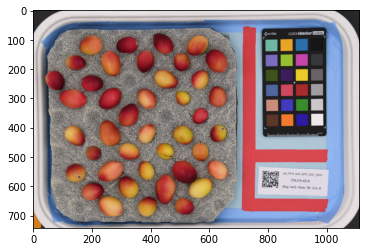

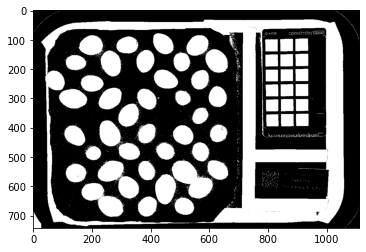

In [122]:
plt.imshow(img3)
plt.show()

berry_mask = bayes_class_mask['berry']
plt.imshow(berry_mask, cmap = "gray")
plt.show()